# Linear Regression and Classification in PyTorch


## Part 1: Regression warm-up

During the warm-up, you will undertake the following steps:

1. **Dataset Preparation**: Load the diabetes dataset from sklearn.datasets, split it into training and testing sets, standardize the features for neural network compatibility, and convert them into PyTorch tensors.


1. **Model Building**: Create two types of models in PyTorch - a simple Linear Regression Model and a more complex Deep Neural Network for regression. The Linear Regression Model will use a single linear layer, and the deep network will incorporate multiple layers with **ReLU** activations.


1. **Training and Testing**: Both models will be trained on the training dataset. Use Mean Squared Error (MSE) as your loss function and Stochastic Gradient Descent (SGD) as the optimizer. Implement a training loop to update the model weights and periodically evaluate the model on the test set.


1. **Evaluation**: After training, evaluate the final performance of the models on the test set and understand how well your models predict diabetes outcomes.


1. **Learning Rate Experimentation**: Experiment with different learning rates (1, 0.1, 0.01, ..., 1e-7) and analyze their impact on the training and test losses. Specifically, examine the differences in the effects of various learning rates for a given model and compare the behavior of the same learning rate between the shallow and deep networks.

In [1]:
# You probably won't need additional imports for this part
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F # ReLU is here

In [2]:
# Load and Prepare the Dataset
diabetes_data = load_diabetes()
X, y = diabetes_data.data, diabetes_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (353, 10)
X_test shape: (89, 10)
y_train shape: (353,)
y_test shape: (89,)


In [4]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Theoretical questions

Q1: Why do we need to scale the data? What will happen if we forget this step?


Q2: Why are we using the training set parameters to perform the scaling on both training and testing datasets? What is the problem with scaling the datasets according to all the data (train+test) or to scale the training and testing separately?

## Your answers in this cell

A1: If our data features are on different scales and we neglect to scale them, optimization methods such as gradient descent may struggle to converge efficiently to the minimum point. The presence of varied scales can make it challenging for the optimizer to navigate the parameter space effectively. On the other hand, when features are on the same scale, the optimization process becomes more stable and efficient.

A2: Using the training set parameters for scaling on both training and testing datasets prevents data leakage, simulates real-world scenarios, and promotes generalization by ensuring consistent scaling across all data. Scaling separately may lead to inconsistent predictions due to different scaling parameters.

In [5]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [6]:
class LinearRegressionModel(nn.Module):
    '''    
    Every network in PyTorch can (and should) be defined as a class.
    Every class should have an init method containing the layers and a forward 
    method that defines how the layers are connected. This is often called 
    the architecture of the network.

    A linear regression model predicts a continuous value using a linear function.
    In PyTorch, this can be implemented using a fully connected layer without any 
    activation functions (also known as a Linear layer in PyTorch).

    Define a linear regression model with a single Linear layer.
    Documentation: https://pytorch.org/docs/stable/nn.html#linear-layers
    '''
    def __init__(self, n_features):
        super(LinearRegressionModel, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Define a single linear layer. The layer should take 'n_features' as input #
        # and output a single value (regression).                                   #
        # This function has no return value.                                        #
        #############################################################################
        self.linear = nn.Linear(n_features, 1)
        
    def forward(self, x):
        y_hat = None
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward pass through your linear layer.                        #
        # Simply pass 'x' through the linear layer and return the output.           #
        # No activation functions are needed for linear regression.                 #
        #############################################################################
        y_hat = self.linear(x)
        return y_hat

In [7]:
def train_and_test_model(model, X_train, y_train, X_test, y_test, num_epochs, criterion, optimizer):
    '''
    This function handles the training. It takes the model, data, number of iterations,
    loss function and optimizer and performs training and logging of loss values for
    debugging and analysis. This function should work for both the linear regression 
    model and the deep model, without any specific checks.
    '''
    
    train_losses = []
    test_losses = []
    model.train()
    for epoch in range(num_epochs):
        #############################################################################
        # TO DO:                                                                    #
        # Train the network. We use full-batch gradient descent, so every iteration #
        # goes over the entire training set. Then, zero the  gradients by using     #
        # optimizer.zero_grad(), perform a forward prop and calculate the loss.     #
        # Afterwards, calculate the gradients and backprob using loss.backward()    #
        # and perform the optimization step by using optimizer.step().              #
        # Use the provided stats loguc log useful information during training.      #
        #############################################################################
        # Forward pass (use model to get outputs, and calculate loss)
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train.reshape(-1,1))
        
        # Backward pass: zero gradients, calculate gradients and do the update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        train_losses.append(loss.item())

        # Test the model every 100 epochs
        if (epoch + 1) % 100 == 0:
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                y_predicted = model(X_test)
                test_loss = criterion(y_predicted, y_test.view(-1, 1))
                test_losses.append(test_loss.item())
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
            model.train()  # Set the model back to training mode

    # Final test
    model.eval()
    with torch.no_grad():
        y_predicted = model(X_test)
        test_loss = criterion(y_predicted, y_test.view(-1, 1))
        print(f'Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses


In [8]:
learning_rates = [1,0.1, 0.01, 0.001, 0.0001, 0.00001, 1e-6, 1e-7]
min_test_loss = float('inf')
best_lr = None
num_epochs = 1000

for lr in learning_rates:
    linear_model = LinearRegressionModel(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(linear_model.parameters(), lr=lr)
    
    print(f"\nLearning Rate: {lr}")
    train_losses, test_losses = train_and_test_model(linear_model, 
                                                     X_train, y_train, 
                                                     X_test, y_test, 
                                                     num_epochs, 
                                                     criterion, 
                                                     optimizer)
    current_min_test_loss = min(test_losses)
    if current_min_test_loss < min_test_loss:
        min_test_loss = current_min_test_loss
        best_lr = lr


print(f"\nMinimum Test Loss: {min_test_loss:.4f} at Learning Rate: {best_lr}\n")


linear_model = LinearRegressionModel(X_train.shape[1])
criterion = nn.MSELoss()


optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.1) #adjusting lr

train_losses, test_losses = train_and_test_model(linear_model, 
                                                 X_train, y_train, 
                                                 X_test, y_test, 
                                                 num_epochs, 
                                                 criterion, 
                                                 optimizer)


Learning Rate: 1
Epoch [100/1000], Loss: nan, Test Loss: nan
Epoch [200/1000], Loss: nan, Test Loss: nan
Epoch [300/1000], Loss: nan, Test Loss: nan
Epoch [400/1000], Loss: nan, Test Loss: nan
Epoch [500/1000], Loss: nan, Test Loss: nan
Epoch [600/1000], Loss: nan, Test Loss: nan
Epoch [700/1000], Loss: nan, Test Loss: nan
Epoch [800/1000], Loss: nan, Test Loss: nan
Epoch [900/1000], Loss: nan, Test Loss: nan
Epoch [1000/1000], Loss: nan, Test Loss: nan
Test Loss: nan

Learning Rate: 0.1
Epoch [100/1000], Loss: 2745.8733, Test Loss: 3461.1448
Epoch [200/1000], Loss: 2742.3428, Test Loss: 3453.8999
Epoch [300/1000], Loss: 2739.9561, Test Loss: 3448.1145
Epoch [400/1000], Loss: 2738.3186, Test Loss: 3443.5305
Epoch [500/1000], Loss: 2737.1946, Test Loss: 3439.8879
Epoch [600/1000], Loss: 2736.4224, Test Loss: 3436.9792
Epoch [700/1000], Loss: 2735.8921, Test Loss: 3434.6443
Epoch [800/1000], Loss: 2735.5278, Test Loss: 3432.7620
Epoch [900/1000], Loss: 2735.2778, Test Loss: 3431.2371
Ep

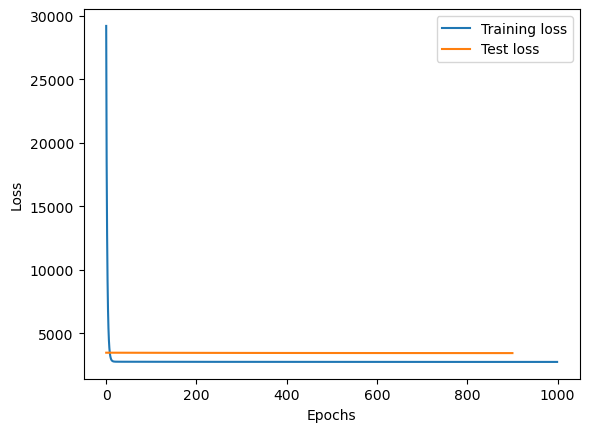

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(np.arange(0, num_epochs, 100), test_losses, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now you will create a deep neural network, with non-linear activations.

In [10]:
class DeepRegressionModel(nn.Module):
    '''
    A deep neural network for regression can have multiple layers.
    Each layer is fully connected, followed by a non-linear activation 
    function (except for the output layer in regression models).

    Define a network with multiple Linear layers and ReLU activations.
    Documentation:
    - Activation functions: https://pytorch.org/docs/stable/nn.html#non-linear-activation-functions
    '''
    def __init__(self, n_features):
        super(DeepRegressionModel, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Define multiple linear layers. You can choose the number of layers and    #
        # the number of neurons in each layer. The first layer should take          #
        # 'n_features' as input. The final layer should output a single value.      #
        # This function has no return value.                                        #
        #############################################################################
        #I decided to create 3 layers regression model
        self.layer1 = nn.Linear(n_features,50)
        self.relu1 = nn.ReLU()
        
        self.layer2 = nn.Linear(50,20)
        self.relu2 = nn.ReLU()
        
        self.layer3 = nn.Linear(20,1)

    def forward(self, x):
        y_hat = None
        #############################################################################
        # TO DO:                                                                    #
        # Connect the layers you defined in __init__. Use ReLU activation functions #
        # after each layer except the last one. The output should be a single value #
        # from the final layer.                                                     #
        #############################################################################
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        y_hat = self.layer3(x)

        return y_hat

In [11]:
num_epochs = 1000
learning_rates = [1,0.1, 0.01, 0.001, 0.0001, 0.00001, 1e-6, 1e-7]


for lr in learning_rates:
    deep_model = DeepRegressionModel(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(deep_model.parameters(),lr=lr)
    
    print(f"\nLearning Rate: {lr}")
    train_losses, test_losses = train_and_test_model(deep_model, 
                                                 X_train, y_train, 
                                                 X_test, y_test, 
                                                 num_epochs, 
                                                 criterion, 
                                                 optimizer)

    current_min_test_loss = min(test_losses)
    if current_min_test_loss < min_test_loss:
        min_test_loss = current_min_test_loss
        best_lr = lr


print(f"\nMinimum Test Loss: {min_test_loss:.4f} at Learning Rate: {best_lr}\n")


num_epochs = 1000
deep_model = DeepRegressionModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(deep_model.parameters(),lr=1e-05) #Adjusting lr

train_losses, test_losses = train_and_test_model(deep_model, 
                                                 X_train, y_train, 
                                                 X_test, y_test, 
                                                 num_epochs, 
                                                 criterion, 
                                                 optimizer)


Learning Rate: 1
Epoch [100/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [200/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [300/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [400/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [500/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [600/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [700/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [800/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [900/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Epoch [1000/1000], Loss: 492400934912.0000, Test Loss: 492404506624.0000
Test Loss: 492404506624.0000

Learning Rate: 0.1
Epoch [100/1000], Loss: 6130.6978, Test Loss: 5134.7832
Epoch [200/1000], Loss: 6130.6978, Test Loss: 5134.7832
Epoch [300/1000], Loss: 6130.6978, Test Loss: 5134.7832
Epoch [400/1000], Loss: 6130.6978, Test Loss

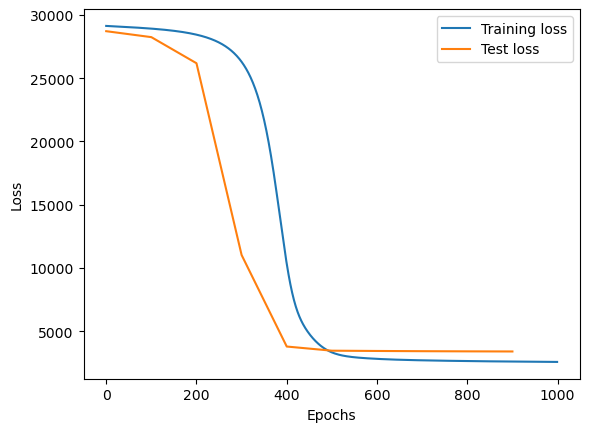

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(np.arange(0, num_epochs, 100), test_losses, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Theoretical Question

Observe and document how each architecture and learning rate affects the training and test losses. Your observations might include outcomes like incomplete training, model convergence or divergence and the loss values (on the training and testing) at the end of training. Explain the reasons behind the different behaviors observed at each learning rate.

### Your answer 

Answer: 

#### Learning Rate: 1.0

- The model experiences extremely large loss values during training, which indicates divergence.
- The learning rate is too high, causing the optimization process to overshoot the minimum and result in instability.

#### Learning Rate: 0.1

- The model converges, but the training and test losses are not decreasing significantly.
- The learning rate might still be too high, preventing the model from fine-tuning its parameters effectively.

#### Learning Rate: 0.01

- The model converges and the training and test losses decrease.
- This learning rate is relatively suitable, leading to a stable convergence and improvement in performance.

#### Learning Rate: 0.001

- The model converges well, and both training and test losses decrease consistently.
- This learning rate is effective in finding a good balance between convergence speed and stability.

#### Learning Rate: 0.0001

- The model converges, and the training and test losses decrease.
- A lower learning rate allows for more precise parameter updates, resulting in a smoother convergence.

#### Learning Rate: 1e-05

- The model converges, and the training and test losses decrease.
- The learning rate is quite low, which can lead to slow convergence, but it seems to be effective in this case.

#### Learning Rate: 1e-06

- The model converges, and the training and test losses decrease.
- This learning rate is very low, causing slower convergence, but the model still reaches a reasonable solution.

#### Learning Rate: 1e-07

- The model converges, and the training and test losses decrease.
- This learning rate is excessively low, resulting in very slow convergence. It might not be practical in many scenarios due to its extremely slow learning pace.


- Overall, the best learning rate appears to be 1e-05, as it achieves a good balance between convergence speed and stability, leading to the minimum test loss. Higher learning rates lead to divergence, while lower learning rates result in slower convergence, which may not be practical in real-world applications. The choice of an appropriate learning rate depends on the specific problem and dataset, and tuning may be necessary to find the optimal value.

## Part 2: Image Classification

During this part, you will do the following:

1. **Dataset Preparation**: Load the MNIST and CIFAR-10 datasets from PyTorch. Those datasets contain images that are slightly different to handle when compared to tabular data. Note that we will use a dataloader, a dedicated PyTorch class that handles data for you. This notebook includes some basic usage of dataloaders for your reference.

1. **Model Building**: Create a single activated model in PyTorch. Note that a larger network will take significantly more time to train and that we are no longer solving a regression problem, but a classification problem. Make sure you are using a proper loss function and that the number of outputs of your network fits the data.

1. **Training and Testing**: The model will be trained on the training dataset. Use cross-entropy as your loss function and Stochastic Gradient Descent (SGD) as the optimizer. Implement a training loop to update the model weights and periodically evaluate the model on the test set.

1. **Evaluation**: After training, evaluate the final performance of the model on the test set.

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

PyTorch comes with several datasets ready for use in the torchvision package. This feature is highly usefull since obtaining and preprocessing datasets can be tedious and time consuming. The following commands will download the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset to your computer. Notice the parameters for the `DataLoader` function: we specify the root folder in which the dataset will be downloaded to. We use two different datasets - one for training and one for testing. Since neural networks can easily learn complex functions, we need to test the generalization capabilities of our network using data it have not seen before. Most mertics use the test data to measure how well the network perform. The `batch_size` parameter determines the number of images and their corresponding labels in each batch.

In [14]:
# Transforms is a usefull library containing many operations on images.
# Since the MNIST dataset is stored as PIL images, we need to transform it into tensors
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=4, shuffle=True, num_workers=0)
mnist_dataset_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=4, shuffle=True, num_workers=0)

classes = [x for x in range(10)] # We use this notation for easy code recycling

We will use a simple function to display the images in our dataset. Since PyTorch saves images in a channels first format, we need to rearrange the tensor using `np.transpose()` function. The following code snippet

torch.Size([4, 1, 28, 28])
Ground Truth:     9     5     5     4


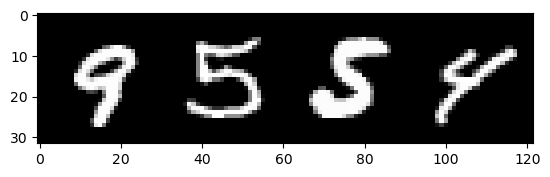

In [15]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(mnist_trainloader)
images, labels = next(dataiter)
print(images.shape)
imshow(torchvision.utils.make_grid(images))
print('Ground Truth:',' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
type(images[0][0][0]), type(labels[0])

(torch.Tensor, torch.Tensor)

In [17]:
labels

tensor([9, 5, 5, 4])

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    '''
    Define the basic architecture of your network. 
    For now, you should only use fully connected layers.
    '''
    def __init__(self):
        super(MNIST_Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Define the basic architecture of your network. For now, only use fully    #
        # connected layers. Read about calling fully connected layers at:           #
        # https://pytorch.org/docs/stable/nn.html#linear-layers                     #
        # In this function, you should only define the layers you intend to use.    #
        # Save each layer as a different *self variable*.                           #
        # This function has no return value.                                        #
        #############################################################################
        
        self.layer1 = nn.Linear(28*28, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250, 10) #classify into 10 classes (0-9)
        
        
    def forward(self, x):
        y_hat = None
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation of your network. Connect each layer to     #
        # the next and experiment with different activations, number of parameters  #
        # and depths. You can read about different activations in PyTorch at        #
        # https://pytorch.org/docs/stable/nn.html#non-linear-activation-functions   #
        # Return a single tensor after passing it through your network.             #
        # Hint: Shaping a multidimensional tensor into a vector can be achieved by: #
        # the method x.view()                                                       #
        #############################################################################
        
        x = x.view(-1, 28*28*1)  #(batch size, W*H*C) the channel = 1 because its black and white
        x = F.relu(self.layer1(x))  
        x = F.relu(self.layer2(x))  
        y_hat = self.layer3(x) 
        return y_hat
    
mnist_net = MNIST_Net().to(device)

In [19]:
import torch.optim as optim
#############################################################################
# TO DO:                                                                    #
# Pick a loss function and optimizer for your network. Start with a cross-  #
# entropy loss and stochastic gradient descent with 0.001 learning rate and #
# test the effect of different learning rates and momentum.                 #
# Use the documentation and create variables to hold the loss function and  #
# optimizer. The model will take them as inputs for the training process    #
#############################################################################

criterion = nn.CrossEntropyLoss() # -log(yi hat)
optimizer = optim.Adam(mnist_net.parameters(),lr = 0.001)
#optimizer = optim.SGD(mnist_net.parameters(),lr = 0.001)

In [20]:
def train_network(net, critertion, optimizer, trainloader):
    net.train()
    #############################################################################
    # TO DO:                                                                    #
    # Train your network. Use the train loader to fetch a batch of data and     #
    # labels (use the provided reference in the cells above.                    # 
    # Then, zero the parameter gradients by using optimizer.zero_grad()         #
    # and perform a forward propagation and calculate the loss. Afterwards,     #
    # calculate the gradients and backprob using loss.backward(), and perform   #
    # the optimization step by using optimizer.step(). Use the provided         #
    # statistics function to print useful information during training.          #
    # Two iteration over the entire dataset (2 epochs) should be enough.        #
    # We print the loss every 2000 batches to babysit the learning process.     #
    #############################################################################
    for epoch in range(2):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs from the dataloader
            data_inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hats = net(data_inputs)
            loss = criterion(y_hats, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training')
   

In [21]:
%%time
train_network(mnist_net, criterion, optimizer, mnist_trainloader)

[1,  2000] loss: 0.433
[1,  4000] loss: 0.228
[1,  6000] loss: 0.193
[1,  8000] loss: 0.160
[1, 10000] loss: 0.168
[1, 12000] loss: 0.143
[1, 14000] loss: 0.138
[2,  2000] loss: 0.108
[2,  4000] loss: 0.114
[2,  6000] loss: 0.115
[2,  8000] loss: 0.115
[2, 10000] loss: 0.113
[2, 12000] loss: 0.105
[2, 14000] loss: 0.094
Finished Training
Wall time: 11min 20s


If everything works, the loss of the network should improved over time as it learns to classify hand-written digits.
In order to measure how well the network performs, we need the test dataset.
We classify each image in the test dataset (that the network never saw) and calculate the accuracy of the network. A good model should generalize and perform well even on data that was not seen during training.

In [22]:
def calc_net_accuracy(net, testloader):
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

calc_net_accuracy(mnist_net, mnist_testloader)

Accuracy of the network on the 10000 test images: 97 %


- I tried to use lr = 0.001 and SGD optimizer with output of 1000 from the first layer and output of 500 from the second layer and the best accuracy result i received was 91%, i will try now the 'Adam' optimizer in order to get better results.


- Best results Hyperparameters: 
    - Learning Rate = 0.001
    - Loss Function = Cross Entropy
    - Optimizer Method: Adam
    - Output Dimension first layer = 500
    - Output Dimension second layer = 250

A simple network can achieve results of over 95%. Try several network architectures until you reach at least 93% accuracy.

We can also take a batch and visualize the predictions:

Ground Truth:      0     9     3     3
Predicted   :      0     9     3     3


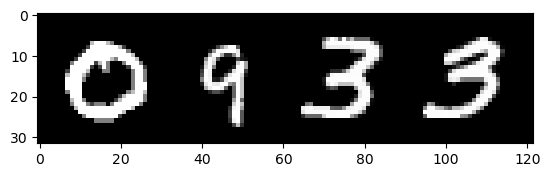

In [23]:
dataiter = iter(mnist_testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = mnist_net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted   : ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

We can also check the individual classification scores for each class in the dataset.

In [24]:
def calc_class_accuracy(net, testloader):
    net.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

calc_class_accuracy(mnist_net, mnist_testloader)

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 97 %
Accuracy of     4 : 96 %
Accuracy of     5 : 95 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %


We have implemented a simple neural network in PyTorch that predicts hand-written characters that scores over 95% in a matter of seconds. Next, we try to use the same network with more complicated data. This time, we will use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

# CIFAR-10

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=32, shuffle=True, num_workers=2)

cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


     plane       deer        cat       bird


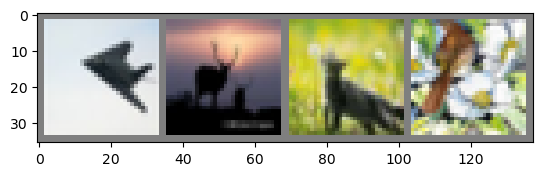

In [26]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [32]:
class CIFAR_Net(nn.Module):
#############################################################################
# TO DO:                                                                    #
# Use the architecture you used for the MNIST dataset. Change the size      #
# of the *input* to support images from the CIFAR-10 dataset.               #
#############################################################################
    
    def __init__(self):
        super(CIFAR_Net, self).__init__()
        self.layer1 = nn.Linear(32*32*3, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250, 10) #classify into 10 classes ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        
    def forward(self, x):
        y_hat = None
        x = x.view(-1, 32*32*3)  #(batch size, W*H*C) channel = 3 because its RGB
        x = F.relu(self.layer1(x))  
        x = F.relu(self.layer2(x))  
        y_hat = self.layer3(x) 
        return y_hat
    
    
cifar_net = CIFAR_Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_net.parameters(), lr=0.01, momentum=0.9)

In [33]:
def train_network(net, critertion, optimizer, trainloader):
    net.train()
    #############################################################################
    # TO DO:                                                                    #
    # Train your network. Use the train loader to fetch a batch of data and     #
    # labels. Then, zero the parameter gradients by using optimizer.zero_grad() #
    # and perform a forward propagation and calculate the loss. Afterwards,     #
    # calculate the gradients and backprob using loss.backward(), and perform   #
    # the optimization step by using optimizer.step(). Use the provided         #
    # statistics function to print useful information during training.          #
    # Two iteration over the entire dataset (2 epochs) should be enough.        #
    # Print the loss every 2000 batches to babysit the learning process.        #
    #############################################################################
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    for epoch in range(15):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs from the dataloader
            data_inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hats = net(data_inputs)
            loss = criterion(y_hats, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0


    print('Finished Training')

In [34]:
%%time
train_network(cifar_net, criterion, optimizer, cifar_trainloader)

cpu
[1,  1563] loss: 1.291
[2,  1563] loss: 1.113
[3,  1563] loss: 1.030
[4,  1563] loss: 0.965
[5,  1563] loss: 0.904
[6,  1563] loss: 0.854
[7,  1563] loss: 0.805
[8,  1563] loss: 0.755
[9,  1563] loss: 0.710
[10,  1563] loss: 0.669
[11,  1563] loss: 0.625
[12,  1563] loss: 0.593
[13,  1563] loss: 0.555
[14,  1563] loss: 0.521
[15,  1563] loss: 0.501
Finished Training
Wall time: 8min 29s


In [35]:
calc_net_accuracy(cifar_net, cifar_testloader)

Accuracy of the network on the 10000 test images: 52 %


GroundTruth:      cat    ship    ship   plane    frog    frog     car    frog
Predicted:       deer     car    ship   plane    deer    frog     car    frog


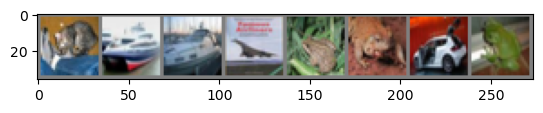

In [44]:
dataiter = iter(cifar_testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(8)))

outputs = cifar_net(images[:8].to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%7s' % classes[predicted[j]]for j in range(8)))

While we can predicting MNIST data with 95%+ accuracy, we are only able to predict less than half of the CIFAR-10 dataset using the same architecture. The reason is that CIFAR-10 data is more complicated, and we need a more powerful network to handle this data.

## Kindly reminder

Remember that the submission includes this notebook with your ID as the filename. For example, `123456789_987654321.ipynb` if you submitted in pairs and `123456789.ipynb` if you submitted the exercise alone. 